In [302]:
import pandas as pd
import numpy as np
import requests
import json
import geopandas as gpd

# Getting the data of features

## 1) Getting number of subway entrances/exits in each neighborhood as a measure of neighborhood public transport accessibility


### Data source of zillow neighborhood shapefiles:

In [4]:
# nyc neighborhood shapefile data
# downloaded from https://www.zillowgroup.com/developers/api/public-data/neighborhood-boundaries/
# data trimmed to just Manhattan and Brooklyn

zillow_path = 'zillow-neighborhoods-trimmed.geojson'
zillow_hoods = gpd.read_file(zillow_path)
zillow_hoods.head()

,city,name,geo_point_2d,county,state,stroke,stroke-width,stroke-opacity,fill,fill-opacity,geometry
0,New York,Bedford Stuyvesant,"[ 40.687759938868815, -73.940573981689056 ]",Kings,NY,None,NaN,NaN,None,NaN,"POLYGON ((-73.92459 40.69091, -73.94131 40.700..."
1,New York,Upper West Side,"[ 40.787170789188018, -73.976793728411437 ]",New York,NY,None,NaN,NaN,None,NaN,"POLYGON ((-73.95835 40.80072, -73.95966 40.801..."
2,New York,Crown Heights,"[ 40.671408729242359, -73.943746278220274 ]",Kings,NY,None,NaN,NaN,None,NaN,"POLYGON ((-73.95821 40.67989, -73.95880 40.680..."
3,New York,Marble Hill,"[ 40.875594231563134, -73.910634545096684 ]",New York,NY,None,NaN,NaN,None,NaN,"POLYGON ((-73.91072 40.87890, -73.91169 40.879..."
4,New York,Greenwich Village,"[ 40.732443703080406, -73.997078306246877 ]",New York,NY,None,NaN,NaN,None,NaN,"POLYGON ((-73.98734 40.73372, -73.98853 40.734..."


### Data source of subway exit point data:

In [6]:
# nyc entrances and exits location data
path = 'https://data.cityofnewyork.us/api/geospatial/drex-xx56?method=export&format=GeoJSON'
nyc_exits = gpd.read_file(path)
print(nyc_exits.shape)
nyc_exits.head()

(1928, 5)


,line,name,objectid,url,geometry
0,2-5,Birchall Ave & Sagamore St at NW corner,1734,http://web.mta.info/nyct/service/,POINT (-73.86836 40.84917)
1,2-5,Birchall Ave & Sagamore St at NE corner,1735,http://web.mta.info/nyct/service/,POINT (-73.86821 40.84913)
2,2-5,Morris Park Ave & 180th St at NW corner,1736,http://web.mta.info/nyct/service/,POINT (-73.87350 40.84122)
3,2-5,Morris Park Ave & 180th St at NW corner,1737,http://web.mta.info/nyct/service/,POINT (-73.87289 40.84145)
4,2-5,Boston Rd & 178th St at SW corner,1738,http://web.mta.info/nyct/service/,POINT (-73.87962 40.84082)


### Loop to find number of points in each neighborhood polygon:

In [7]:
# Make a copy because I'm going to drop points as I
# assign them to polys, to speed up subsequent search.
pts = nyc_exits.copy() 

# We're going to keep a list of how many points we find.
pts_in_polys = []

# Loop over polygons with index i.
for i, poly in zillow_hoods.iterrows():

    # Keep a list of points in this poly
    pts_in_this_poly = []

    # Now loop over all points with index j.
    for j, pt in pts.iterrows():
        if poly.geometry.contains(pt.geometry):
            # Then it's a hit! Add it to the list,
            # and drop it so we have less hunting.
            pts_in_this_poly.append(pt.geometry)
            pts = pts.drop([j])

    # We could do all sorts, like grab a property of the
    # points, but let's just append the number of them.
    pts_in_polys.append(len(pts_in_this_poly))

# Add the number of points for each poly to the dataframe.
zillow_hoods['number_of_exits'] = gpd.GeoSeries(pts_in_polys)

<ipython-input-7-df299b7b33a2>:27: FutureWarning:     You are passing non-geometry data to the GeoSeries constructor. Currently,
    it falls back to returning a pandas Series. But in the future, we will start
    to raise a TypeError instead.
  zillow_hoods['number_of_exits'] = gpd.GeoSeries(pts_in_polys)


In [9]:
zillow_hoods.head()

,city,name,geo_point_2d,county,state,stroke,stroke-width,stroke-opacity,fill,fill-opacity,geometry,number_of_exits
0,New York,Bedford Stuyvesant,"[ 40.687759938868815, -73.940573981689056 ]",Kings,NY,None,NaN,NaN,None,NaN,"POLYGON ((-73.92459 40.69091, -73.94131 40.700...",34
1,New York,Upper West Side,"[ 40.787170789188018, -73.976793728411437 ]",New York,NY,None,NaN,NaN,None,NaN,"POLYGON ((-73.95835 40.80072, -73.95966 40.801...",49
2,New York,Crown Heights,"[ 40.671408729242359, -73.943746278220274 ]",Kings,NY,None,NaN,NaN,None,NaN,"POLYGON ((-73.95821 40.67989, -73.95880 40.680...",20
3,New York,Marble Hill,"[ 40.875594231563134, -73.910634545096684 ]",New York,NY,None,NaN,NaN,None,NaN,"POLYGON ((-73.91072 40.87890, -73.91169 40.879...",2
4,New York,Greenwich Village,"[ 40.732443703080406, -73.997078306246877 ]",New York,NY,None,NaN,NaN,None,NaN,"POLYGON ((-73.98734 40.73372, -73.98853 40.734...",38


### Plot exits onto neighborhood shapefile:

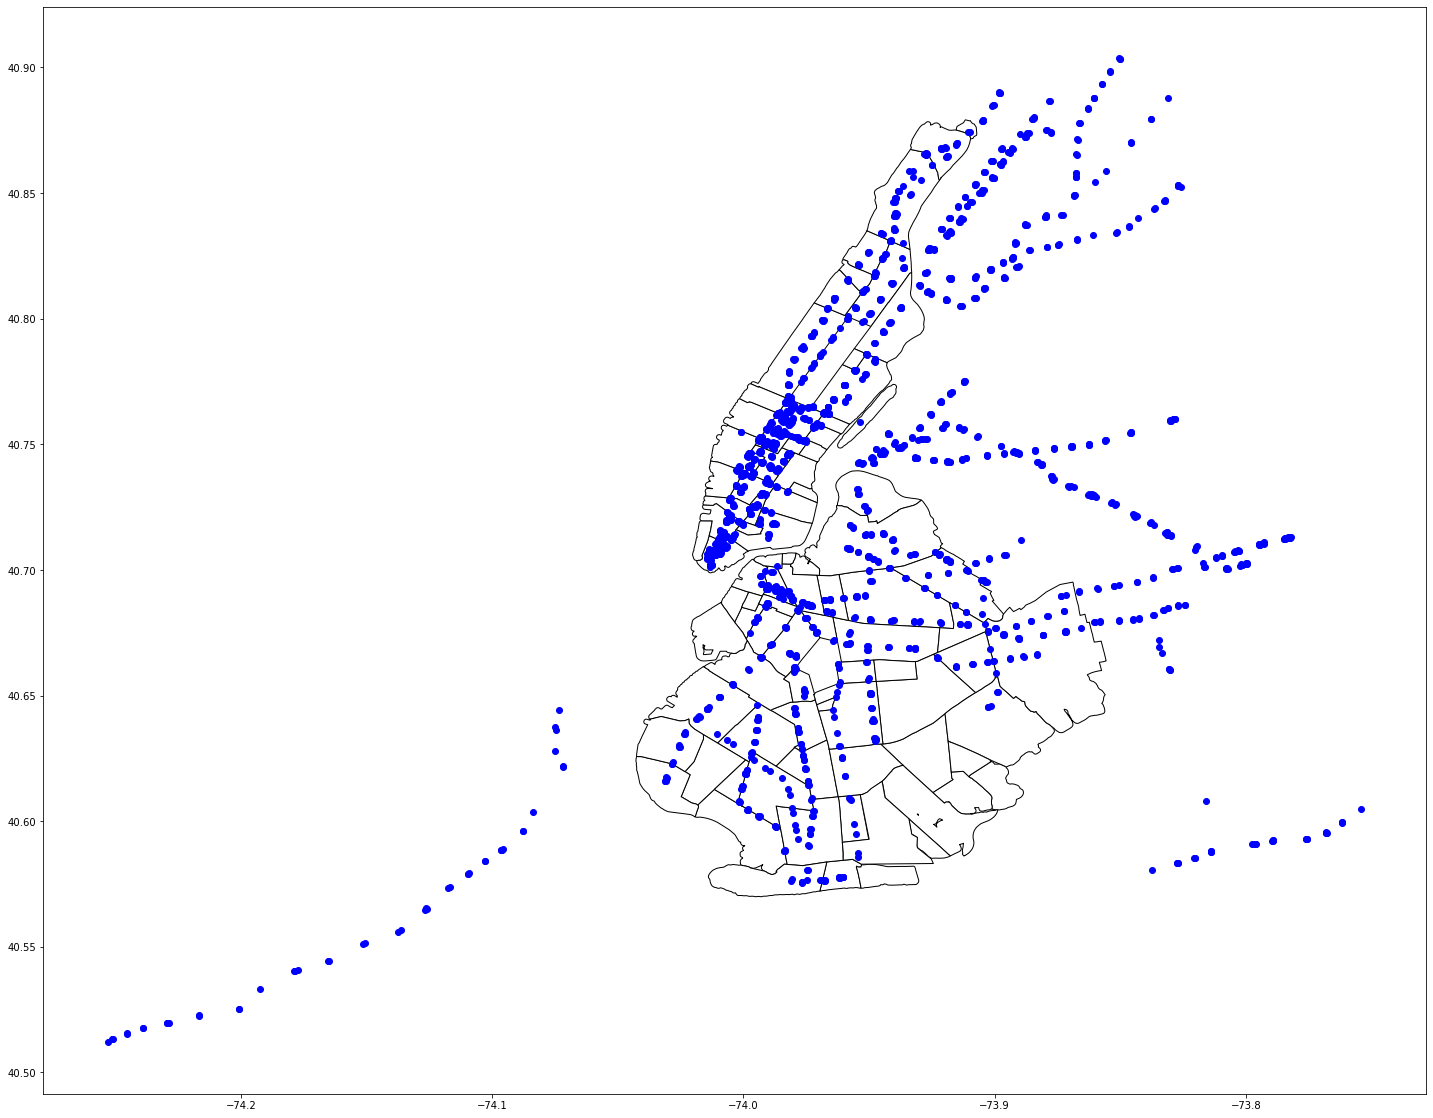

In [14]:
import matplotlib.pyplot as plt
# also install descartes package

# Plot shape map of neighborhoods
ax = zillow_hoods.plot(color='white', edgecolor='black', figsize=(40,20))

# We can now plot our exits.
nyc_exits.plot(ax=ax, color='blue')

plt.show()

### Filter down df:

In [15]:
# Filter down zillow_hoods df
filtered = zillow_hoods[['name', 'county','number_of_exits', 'geometry']]

In [16]:
# narrow data to only brooklyn and manhattan
filtered = filtered[filtered['county'].isin(['New York', 'Kings'])]

# check data
#filtered.groupby(['county'])[['name']].count()

#sort by ntaname
filtered.sort_values(by=['name'], ascending=True, inplace=True)

# reset index
filtered.reset_index(drop=True, inplace=True)

## 2) Getting foursquare venue data points inside a neighborhood shapefile:

### Clean data for foursquare:  
1) Simplify each neighborhood shapefile  
2) Keep only biggest neighborhood shapefile

In [17]:
# simplify the neighborhood shapefile
filtered['geom_simplified'] = filtered['geometry'].simplify(0.1, preserve_topology=True)

In [ ]:
# converted a few shapefiles that were multipolygons into polygons by retaining only the largest polygon
row_number = [1, 12, 25, 43, 45, 48, 52, 63, 65, 68, 77, 78, 79]

for x in row_number:
    filtered['geom_simplified'].iloc[x] = max(filtered['geom_simplified'].iloc[x], key=lambda a:a.area)

In [26]:
filtered.head()

,name,county,number_of_exits,geometry,geom_simplified
0,Bath Beach,Kings,8,"POLYGON ((-73.99401 40.60217, -73.99546 40.603...","POLYGON ((-73.99401 40.60217, -74.01158 40.612..."
1,Battery Park,New York,0,"POLYGON ((-74.01671 40.71956, -74.01682 40.719...","POLYGON ((-74.01671 40.71956, -74.02025 40.706..."
2,Bay Ridge,Kings,7,"POLYGON ((-74.03275 40.64167, -74.03591 40.640...","POLYGON ((-74.03275 40.64167, -74.04256 40.625..."
3,Bedford Stuyvesant,Kings,34,"POLYGON ((-73.92459 40.69091, -73.94131 40.700...","POLYGON ((-73.92459 40.69091, -73.94133 40.700..."
4,Bensonhurst,Kings,22,"POLYGON ((-73.99075 40.62412, -73.99270 40.625...","POLYGON ((-73.99075 40.62412, -74.00152 40.606..."


### Workaround to get URL string for foursquare API call:

In [27]:
# convert geometry to string
filtered['geom_simplified_str'] = filtered['geom_simplified'].apply (lambda g: g.wkt)

In [28]:
# manually fixed one row's values which was a box inside a box
filtered.geom_simplified_str.values[56]=filtered.geom_simplified_str.values[56].replace(
        'POLYGON ((-73.93637956799994 40.62214728200006, -73.94360999999989 40.60943, -73.91039478499992 40.58729595100004, -73.89875143799989 40.60452003000005, -73.93637956799994 40.62214728200006), (-73.93076864999993 40.60273286300008, -73.93052568299991 40.60285362200005, -73.93034929199989 40.60234391900006, -73.93076864999993 40.60273286300008), (-73.92392183399991 40.59877534000008, -73.92200369999993 40.60095620000003, -73.92075305699989 40.60044782300007, -73.92298391799993 40.59765855600004, -73.92392183399991 40.59877534000008))',
        'POLYGON ((-73.93637956799994 40.62214728200006, -73.94360999999989 40.60943, -73.91039478499992 40.58729595100004, -73.89875143799989 40.60452003000005, -73.93637956799994 40.62214728200006))')

filtered.geom_simplified_str.values[71]=filtered.geom_simplified_str.values[71].replace(
        'POLYGON ((-74.00026165699994 40.67505363300005, -74.00904190599991 40.68701969300007, -74.01860220799993 40.66531363900008, -73.9999763789999 40.66826741300007, -74.00026165699994 40.67505363300005), (-74.01597515899992 40.66684184800004, -74.01611824199993 40.67022133100004, -74.01208910399991 40.66817749500006, -74.01284746399993 40.66657768900006, -74.01597515899992 40.66684184800004))',
        'POLYGON ((-74.00026165699994 40.67505363300005, -74.00904190599991 40.68701969300007, -74.01860220799993 40.66531363900008, -73.9999763789999 40.66826741300007, -74.00026165699994 40.67505363300005))')

In [29]:
# removed extra string characters in each row
filtered['geom_url'] = filtered['geom_simplified_str'].str.replace('POLYGON \(\(', '')
filtered['geom_url'] = filtered['geom_url'].str.replace('\)\)', '')
filtered['geom_url'] = filtered['geom_url'].str.replace('\,', '')

In [30]:
#split string by space, then rearrange so longitude is first, depending on total number of points in the polygon

final_list=[]
for ind in filtered.index:
    whole_string = filtered['geom_url'][ind]
    list = whole_string.split(' ')
    if len(list) == 10:
        final = list[1]+','+list[0]+';'+list[3]+','+list[2]+';'+list[5]+','+list[4]+';'+list[7]+','+list[6]+';'+list[9]+','+list[8]
    elif len(list) == 12:
        final = list[1]+','+list[0]+';'+list[3]+','+list[2]+';'+list[5]+','+list[4]+';'+list[7]+','+list[6]+';'+list[9]+','+list[8]+';'+list[11]+','+list[10]
    elif len(list) == 16:
        final = list[1]+','+list[0]+';'+list[3]+','+list[2]+';'+list[5]+','+list[4]+';'+list[7]+','+list[6]+';'+list[9]+','+list[8]+';'+list[11]+','+list[10]+';'+list[13]+','+list[12]+';'+list[15]+','+list[14]
    elif len(list) == 22:
        final = list[1]+','+list[0]+';'+list[3]+','+list[2]+';'+list[5]+','+list[4]+';'+list[7]+','+list[6]+';'+list[9]+','+list[8]+';'+list[11]+','+list[10]+';'+list[13]+','+list[12]+';'+list[15]+','+list[14]+';'+list[17]+','+list[16]+';'+list[19]+','+list[18]+';'+list[21]+','+list[20]
    filtered.loc[ind, 'geom_url_rearr'] = final


### Final neighborhood and exit data with foursquare-ready coordinates:

In [35]:
filtered.head()

,name,county,number_of_exits,geometry,geom_simplified,geom_simplified_str,geom_url,geom_url_rearr
0,Bath Beach,Kings,8,"POLYGON ((-73.99401 40.60217, -73.99546 40.603...","POLYGON ((-73.99401 40.60217, -74.01158 40.612...",POLYGON ((-73.99400700999988 40.60216863800007...,-73.99400700999988 40.60216863800007 -74.01157...,"40.60216863800007,-73.99400700999988;40.612664..."
1,Battery Park,New York,0,"POLYGON ((-74.01671 40.71956, -74.01682 40.719...","POLYGON ((-74.01671 40.71956, -74.02025 40.706...",POLYGON ((-74.01671379899993 40.71956434200006...,-74.01671379899993 40.71956434200006 -74.02024...,"40.71956434200006,-74.01671379899993;40.706245..."
2,Bay Ridge,Kings,7,"POLYGON ((-74.03275 40.64167, -74.03591 40.640...","POLYGON ((-74.03275 40.64167, -74.04256 40.625...",POLYGON ((-74.03275211399993 40.64167207200005...,-74.03275211399993 40.64167207200005 -74.04256...,"40.64167207200005,-74.03275211399993;40.625741..."
3,Bedford Stuyvesant,Kings,34,"POLYGON ((-73.92459 40.69091, -73.94131 40.700...","POLYGON ((-73.92459 40.69091, -73.94133 40.700...",POLYGON ((-73.92459322999996 40.69091087200007...,-73.92459322999996 40.69091087200007 -73.94132...,"40.69091087200007,-73.92459322999996;40.700808..."
4,Bensonhurst,Kings,22,"POLYGON ((-73.99075 40.62412, -73.99270 40.625...","POLYGON ((-73.99075 40.62412, -74.00152 40.606...",POLYGON ((-73.99074764047212 40.62412358567712...,-73.99074764047212 40.62412358567712 -74.00152...,"40.62412358567712,-73.99074764047212;40.606975..."


### GET request of venues inside a neighborhood polygon shapefile:

In [37]:
# define foursquare credentials and versions

CLIENT_ID = '4O4VCCNX1WEGIAGACS303HLOQULLJLPXW3HINSTILCBEH2UF'
CLIENT_SECRET = 'MU050U32GGWJSDM1IUO4U4BDKYMJ3IYYGB0ZQOCISUYJFGPW'
VERSION = '20200201'
LIMIT = 150

In [411]:
# Testing a single call for polygon shape

import requests
#test = filtered_df.loc[ind, 'geom_url_rearr']
#polygon = test
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&polygon={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            polygon, 
            LIMIT)

# send the GET request and examine results
results = requests.get(url).json()
results

{'meta': {'code': 200, 'requestId': '5e475f1c0f5968001b0cdfe7'},
 'response': {'groups': [{'items': [{'reasons': {'count': 0,
       'items': [{'reasonName': 'globalInteractionReason',
         'summary': 'This spot is popular',
         'type': 'general'}]},
      'referralId': 'e-0-5845ee5ab6e67d0870d5d083-0',
      'venue': {'categories': [{'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/asian_',
          'suffix': '.png'},
         'id': '52af0bd33cf9994f4e043bdd',
         'name': 'Hotpot Restaurant',
         'pluralName': 'Hotpot Restaurants',
         'primary': True,
         'shortName': 'Hotpot'}],
       'id': '5845ee5ab6e67d0870d5d083',
       'location': {'address': '811 53rd St',
        'cc': 'US',
        'city': 'Brooklyn',
        'country': 'United States',
        'crossStreet': '8th Ave',
        'formattedAddress': ['811 53rd St (8th Ave)',
         'Brooklyn, NY 11220',
         'United States'],
        'labeledLatLngs': [{'label': 'display',
 

In [42]:
# Function to explore nearby venues inside a polygon
def getNearbyVenues(names, polygon):
    
    venues_list=[]
    for name, poly in zip(names, polygon):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&polygon={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            poly, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name,
            v['venue']['id'],
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['ntaname',
                  'Venue_ID',
                  'Venue', 
                  'Venue_Latitude', 
                  'Venue_Longitude', 
                  'Venue_Category']
    
    return(nearby_venues)


In [43]:
ny_venues = getNearbyVenues(names=filtered['name'],
                                polygon=filtered['geom_url_rearr'])

Bath Beach
Battery Park
Bay Ridge
Bedford Stuyvesant
Bensonhurst
Bergen Beach
Boerum Hill
Borough Park
Brighton Beach
Brooklyn Heights
Brownsville
Bushwick
Canarsie
Carnegie Hill
Carroll Gardens
Chelsea
Chinatown
Clinton
Clinton Hill
Cobble Hill
Columbia Street Waterfront District
Columbus Circle
Coney Island
Crown Heights
DUMBO
Downtown
Dyker Heights
East Flatbush
East Harlem
East New York
East Village
Financial District
Flatbush
Flatiron District
Flatlands
Fort Greene
Fort Hamilton
Garment District
Georgetown
Gerritsen Beach
Gowanus
Gramercy
Gravesend
Greenpoint
Greenwich Village
Greenwood
Hamilton Heights
Harlem
Homecrest
Inwood
Kensington
Little Italy
Lower East Side
Manhattan Beach
Manhattanville
Marble Hill
Marine Park
Midtown
Midwood
Mill Basin
Morningside Heights
Murray Hill
Navy Yard
New Utrecht
NoHo
Ocean Hill
Ocean Parkway
Park Slope
Prospect Heights
Prospect Lefferts Gardens
Prospect Park South
Red Hook
Roosevelt Island
Sheepshead Bay
SoHo
Stuyvesant Town
Sunset Park
Sutton

## 3A) Get count of grocery stores/pharmacies venues in each neighborhood

In [47]:
# new df with selected venues
nyc_grocery = ny_venues[ny_venues['Venue_Category'].isin(['Grocery Store', 'Market', 'Organic grocery', 'Bakery', 'Butcher', 'Supermarket', 'Drugstore', 'Pharmacy'])]


In [48]:
nyc_grocery

,ntaname,Venue_ID,Venue,Venue_Latitude,Venue_Longitude,Venue_Category
7,Bath Beach,4f09f19ae4b0596c9037594a,Golden Bun Bakery,40.601962,-73.994025,Bakery
14,Bath Beach,4bba7682b35776b041fbca01,Shan Market,40.589883,-73.991363,Grocery Store
31,Bath Beach,5189575c498e263d5940de13,Lily Bloom Bakery,40.601667,-73.993352,Bakery
41,Bath Beach,4dc86f2952b1b9daeb49d647,Walgreens,40.611522,-74.008693,Pharmacy
44,Bath Beach,57db3140cd107764223b56f9,Tous Les Jour,40.604358,-73.997657,Bakery
...,...,...,...,...,...,...
7743,Windsor Terrace,4aec56f4f964a52028c621e3,One Stop Market,40.647491,-73.973726,Grocery Store
7762,Windsor Terrace,54493f23498e8efab1f1f0b8,Walgreens,40.656766,-73.977771,Pharmacy
7777,Wingate,50bfd9b5e4b08870624451d2,The Market Place,40.662153,-73.943010,Grocery Store
7778,Wingate,4d2ca53c068e8cfa035aee4c,Rite Aid,40.661066,-73.931816,Pharmacy


In [50]:
# one hot encoding
nyc_grocery_onehot = pd.get_dummies(nyc_grocery[['Venue_Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
nyc_grocery_onehot['ntaname'] = nyc_grocery['ntaname'] 


print(nyc_grocery_onehot.shape)
nyc_grocery_onehot.head()


(485, 7)


,Bakery,Butcher,Grocery Store,Market,Pharmacy,Supermarket,ntaname
7,1,0,0,0,0,0,Bath Beach
14,0,0,1,0,0,0,Bath Beach
31,1,0,0,0,0,0,Bath Beach
41,0,0,0,0,1,0,Bath Beach
44,1,0,0,0,0,0,Bath Beach


In [51]:
# Group by neighborhood
nyc_grocery_onehot_tot = nyc_grocery_onehot.groupby('ntaname').sum().reset_index()

In [56]:
print(nyc_grocery_onehot_tot.shape)
nyc_grocery_onehot_tot.head()

(84, 7)


In [59]:
# shape is 84, 7. Missing 5 neighborhoods that don't have any grocery stores
# Financial District, Manhattan Beach, NoHo, Tudor City, Vinegar Hill index:
# So we add it back in

nyc_grocery_onehot_tot.loc[84] = ['Financial District',0,0,0,0,0,0]
nyc_grocery_onehot_tot.loc[85] = ['Manhattan Beach',0,0,0,0,0,0]
nyc_grocery_onehot_tot.loc[86] = ['NoHo',0,0,0,0,0,0]
nyc_grocery_onehot_tot.loc[87] = ['Tudor City',0,0,0,0,0,0]
nyc_grocery_onehot_tot.loc[88] = ['Vinegar Hill',0,0,0,0,0,0]

In [60]:
# sort by ntaname
nyc_grocery_onehot_tot.sort_values(by=['ntaname'], ascending=True, inplace=True)

In [97]:
# get a total column for just grocery stores
nyc_grocery_onehot_tot_sum = nyc_grocery_onehot_tot.drop(['Pharmacy'], axis=1)
nyc_grocery_onehot_tot['groc_totals'] = nyc_grocery_onehot_tot.sum(axis=1)

In [98]:
print(nyc_grocery_onehot_tot.shape)
nyc_grocery_onehot_tot.head()

(89, 8)


,ntaname,Bakery,Butcher,Grocery Store,Market,Pharmacy,Supermarket,groc_totals
0,Bath Beach,3,0,1,0,3,1,13
1,Battery Park,0,0,1,0,0,0,2
2,Bay Ridge,1,0,2,1,1,0,9
3,Bedford Stuyvesant,1,0,2,0,0,0,6
4,Bensonhurst,6,1,2,0,3,0,21


## 3B) Get count of restaurants in each neighborhood

In [64]:
# new df with selected venues
nyc_rest = ny_venues[ny_venues['Venue_Category'].str.contains('Restaurant')]

In [65]:
nyc_rest

,ntaname,Venue_ID,Venue,Venue_Latitude,Venue_Longitude,Venue_Category
1,Bath Beach,4a8d97e5f964a520281020e3,La Casa Bella,40.590570,-73.991666,Italian Restaurant
4,Bath Beach,4a309ae6f964a52084991fe3,Ichi Sushi,40.601774,-73.993869,Sushi Restaurant
17,Bath Beach,55d92840498edb8dc8d7f65e,King's Kitchen,40.603844,-73.996960,Cantonese Restaurant
21,Bath Beach,51f42bb3498e2681264e00a1,Kasumi Sushi & BBQ Restaurant,40.606050,-74.001092,Japanese Restaurant
22,Bath Beach,5a5aaf7cc8b2fb7e920360f0,Em Vietnamese Restaurant,40.608544,-74.004765,Vietnamese Restaurant
...,...,...,...,...,...,...
7764,Windsor Terrace,4a948ca2f964a520f72120e3,Mr. Tong,40.648426,-73.978358,Chinese Restaurant
7782,Wingate,53ab665f498e6ff226301e3b,Under the Sea,40.660861,-73.931153,Seafood Restaurant
7786,Wingate,4b2d5275f964a52010d424e3,White Castle,40.663357,-73.932238,Fast Food Restaurant
7801,Wingate,5accd5796e46504cc781c153,Carl's Jr.,40.655701,-73.942822,Fast Food Restaurant


In [66]:
# one hot encoding
nyc_rest_onehot = pd.get_dummies(nyc_rest[['Venue_Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
nyc_rest_onehot['ntaname'] = nyc_rest['ntaname'] 


print(nyc_grocery_onehot.shape)
nyc_rest_onehot.head()


(485, 7)


,African Restaurant,American Restaurant,Arepa Restaurant,Argentinian Restaurant,Asian Restaurant,Australian Restaurant,Austrian Restaurant,Brazilian Restaurant,Burmese Restaurant,Cajun / Creole Restaurant,...,Tapas Restaurant,Thai Restaurant,Tibetan Restaurant,Turkish Restaurant,Udon Restaurant,Vegetarian / Vegan Restaurant,Venezuelan Restaurant,Vietnamese Restaurant,Yemeni Restaurant,ntaname
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Bath Beach
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Bath Beach
17,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Bath Beach
21,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Bath Beach
22,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,Bath Beach


In [67]:
# Group by neighborhood
nyc_rest_onehot_tot = nyc_rest_onehot.groupby('ntaname').sum().reset_index()

In [74]:
print(nyc_rest_onehot_tot.shape)
#nyc_rest_onehot_tot.to_csv('nycrest.csv')
nyc_rest_onehot_tot

(88, 81)


,ntaname,African Restaurant,American Restaurant,Arepa Restaurant,Argentinian Restaurant,Asian Restaurant,Australian Restaurant,Austrian Restaurant,Brazilian Restaurant,Burmese Restaurant,...,Taiwanese Restaurant,Tapas Restaurant,Thai Restaurant,Tibetan Restaurant,Turkish Restaurant,Udon Restaurant,Vegetarian / Vegan Restaurant,Venezuelan Restaurant,Vietnamese Restaurant,Yemeni Restaurant
0,Bath Beach,0,1,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,2,0
1,Battery Park,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Bay Ridge,0,3,0,0,1,0,0,0,0,...,0,0,0,0,2,0,1,0,0,1
3,Bedford Stuyvesant,1,2,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Bensonhurst,0,0,0,0,1,0,0,0,1,...,0,0,0,0,1,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
83,Washington Heights,0,1,0,0,0,0,0,0,0,...,0,2,2,0,0,0,0,0,0,0
84,West Village,0,2,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,1,0
85,Williamsburg,0,1,1,1,0,0,0,0,0,...,1,1,0,0,0,1,0,0,1,0
86,Windsor Terrace,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [83]:
# shape is 88, 7. Missing 1 neighborhoods that don't have any restaurants
# Navy Yard
# So we add it back in

nyc_rest_onehot_tot.loc[88] = ['Navy Yard',0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]

In [85]:
# sort by ntaname
nyc_rest_onehot_tot.sort_values(by=['ntaname'], ascending=True, inplace=True)

In [88]:
# total restaurant venues per neighborhood
nyc_rest_onehot_tot['resta_totals'] = nyc_rest_onehot_tot.sum(axis=1)

In [89]:
print(nyc_rest_onehot_tot.shape)
#nyc_rest_onehot_tot.to_csv('nycrest.csv')
nyc_rest_onehot_tot

(89, 82)


,ntaname,African Restaurant,American Restaurant,Arepa Restaurant,Argentinian Restaurant,Asian Restaurant,Australian Restaurant,Austrian Restaurant,Brazilian Restaurant,Burmese Restaurant,...,Tapas Restaurant,Thai Restaurant,Tibetan Restaurant,Turkish Restaurant,Udon Restaurant,Vegetarian / Vegan Restaurant,Venezuelan Restaurant,Vietnamese Restaurant,Yemeni Restaurant,resta_totals
0,Bath Beach,0,1,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,2,0,32
1,Battery Park,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,7
2,Bay Ridge,0,3,0,0,1,0,0,0,0,...,0,0,0,2,0,1,0,0,1,33
3,Bedford Stuyvesant,1,2,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,22
4,Bensonhurst,0,0,0,0,1,0,0,0,1,...,0,0,0,1,0,0,0,1,0,36
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
83,Washington Heights,0,1,0,0,0,0,0,0,0,...,2,2,0,0,0,0,0,0,0,26
84,West Village,0,2,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,1,0,33
85,Williamsburg,0,1,1,1,0,0,0,0,0,...,1,0,0,0,1,0,0,1,0,24
86,Windsor Terrace,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,6


## Final df of features

In [104]:
# Grocery store and pharmacy counts
final_df = nyc_grocery_onehot_tot[['ntaname', 'groc_totals']].copy()

In [105]:
# Subway exit counts
final_df['exits'] = filtered['number_of_exits']

In [106]:
final_df['resta_totals'] = nyc_rest_onehot_tot['resta_totals']

In [107]:
#final_df.reset_index(drop=True, inplace=True)
final_df.set_index('ntaname', inplace=True)

In [761]:
final_df

,groc_totals,exits,resta_totals
ntaname,,,
Bath Beach,13,8,32
Battery Park,2,0,7
Bay Ridge,9,7,33
Bedford Stuyvesant,6,34,22
Bensonhurst,21,22,36
...,...,...,...
Washington Heights,10,0,38
West Village,10,9,16
Williamsburg,10,49,13


### Normalize Final df

In [762]:
from sklearn import preprocessing

x = final_df
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
final_df_norm = pd.DataFrame(x_scaled, 
                            columns=['Groceries', 'Pharmacies', 'Subway_exits'])


In [764]:
final_df_norm.index = final_df.index
final_df_norm

,Groceries,Pharmacies,Subway_exits
ntaname,,,
Bath Beach,0.393939,0.1000,0.780488
Battery Park,0.060606,0.0000,0.170732
Bay Ridge,0.272727,0.0875,0.804878
Bedford Stuyvesant,0.181818,0.4250,0.536585
Bensonhurst,0.636364,0.2750,0.878049
...,...,...,...
Washington Heights,0.303030,0.0000,0.926829
West Village,0.303030,0.1125,0.390244
Williamsburg,0.303030,0.6125,0.317073


# Cluster neighborhoods by features

In [765]:
# Finding optimal K

from sklearn.cluster import KMeans

# function returns WSS score for k values from 1 to kmax
def calculate_WSS(points, kmax):
  sse = []
  for k in range(1, kmax+1):
    kmeans = KMeans(n_clusters = k).fit(points)
    centroids = kmeans.cluster_centers_
    pred_clusters = kmeans.predict(points)
    curr_sse = 0
    
    # calculate square of Euclidean distance of each point from its cluster center and add to current WSS
    for i in range(len(points)):
      curr_center = centroids[pred_clusters[i]]
      curr_sse += (points[i, 0] - curr_center[0]) ** 2 + (points[i, 1] - curr_center[1]) ** 2
      
    sse.append(curr_sse)
  return sse

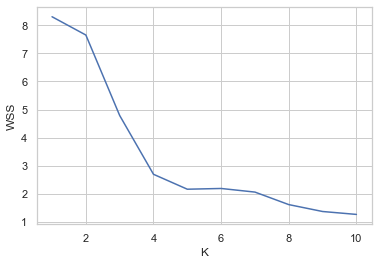

In [770]:
# Calculate WSS
WSS = calculate_WSS(x_scaled, 10)

# Plot K and WSS
K = np.arange(1,11).tolist()
d = {'K':K, 'WSS':WSS}
df =pd.DataFrame(d)

sns.lineplot(x='K', y='WSS', data=df)

In [769]:
# Confirm optimal K with silhouette method

from sklearn.metrics import silhouette_score

sil = []
kmax = 10

# dissimilarity would not be defined for a single cluster, thus, minimum number of clusters should be 2
for k in range(2, kmax+1):
  kmeans = KMeans(n_clusters = k).fit(x_scaled)
  labels = kmeans.labels_
  sil.append(silhouette_score(x_scaled, labels, metric = 'euclidean'))

sil

[0.28624252895487634,
 0.3317647665118502,
 0.3620048651370363,
 0.3514827313210325,
 0.34403454706182535,
 0.33610510689709605,
 0.3446350930451727,
 0.35143262004502906,
 0.35819782410250506]

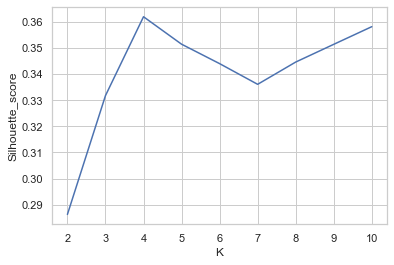

In [771]:
# Plot K and sil
K = np.arange(2,11).tolist()
d2 = {'K':K, 'Silhouette_score':sil}
df2 =pd.DataFrame(d2)

sns.lineplot(x='K', y='Silhouette_score', data=df2)

Combining the information from the elbow method and the silhouette method, the optimal k cluster is 4.

In [772]:
from sklearn.cluster import KMeans

# set number of clusters
kclusters = 4

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(x_scaled)

# check cluster labels generated for each row in the dataframe
kmeans.labels_

array([3, 1, 3, 2, 0, 1, 3, 0, 0, 3, 1, 3, 0, 1, 3, 2, 0, 3, 3, 3, 1, 1,
       1, 3, 1, 2, 0, 3, 0, 2, 3, 2, 2, 3, 2, 3, 3, 3, 2, 1, 1, 3, 0, 3,
       3, 2, 3, 3, 0, 3, 0, 3, 3, 3, 3, 1, 1, 1, 0, 2, 1, 1, 3, 0, 2, 3,
       0, 1, 1, 0, 3, 3, 1, 1, 1, 3, 3, 1, 3, 1, 0, 3, 2, 1, 3, 1, 2, 2,
       3], dtype=int32)

In [773]:
#final_df_norm.drop('Cluster', axis=1, inplace=True)
final_df_norm.insert(0, 'Cluster', kmeans.labels_)


In [774]:
#final_df_norm.index = final_df.index
final_df_norm

,Cluster,Groceries,Pharmacies,Subway_exits
ntaname,,,,
Bath Beach,3,0.393939,0.1000,0.780488
Battery Park,1,0.060606,0.0000,0.170732
Bay Ridge,3,0.272727,0.0875,0.804878
Bedford Stuyvesant,2,0.181818,0.4250,0.536585
Bensonhurst,0,0.636364,0.2750,0.878049
...,...,...,...,...
Washington Heights,3,0.303030,0.0000,0.926829
West Village,1,0.303030,0.1125,0.390244
Williamsburg,2,0.303030,0.6125,0.317073


# Rental prices data

In [134]:
# downloaded from streeteasy rental price per neighborhood data: 
# https://streeteasy-market-data-download.s3.amazonaws.com/rentals/All/medianAskingRent_All.zip
rental_price = pd.read_csv('rental_price.csv')
rental_price

,Unnamed: 0,ntaname,2018-09,2019-09,2019-12,Unnamed: 5,Unnamed: 6,Unnamed: 7
0,0,Bath Beach,1675.0,1795.0,1795.0,NaN,NaN,NaN
1,1,Battery Park,4998.0,4830.0,5118.0,NaN,NaN,NaN
2,2,Bay Ridge,2000.0,1895.0,1950.0,NaN,NaN,NaN
3,3,Bedford Stuyvesant,2550.0,2612.0,2500.0,NaN,NaN,NaN
4,4,Bensonhurst,1900.0,1700.0,1775.0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
84,84,Washington Heights,2200.0,2230.0,2200.0,NaN,NaN,NaN
85,85,West Village,3895.0,4050.0,4250.0,NaN,NaN,NaN
86,86,Williamsburg,3000.0,3500.0,3691.0,NaN,NaN,NaN
87,87,Windsor Terrace,2650.0,2800.0,2500.0,NaN,NaN,NaN


In [135]:
# drop multiple columns
rental_price.drop(rental_price.columns[[0,5,6,7]], axis=1, inplace=True)

In [ ]:
# set index name
rental_price.set_index('ntaname', inplace=True)

In [166]:
# Calculate Year on year change
rental_price['YoY_change'] = (rental_price['2019-09'] - rental_price['2018-09'])/rental_price['2018-09']*100


In [167]:
rental_price

,2018-09,2019-09,2019-12,YoY_change
ntaname,,,,
Bath Beach,1675.0,1795.0,1795.0,7.164179
Battery Park,4998.0,4830.0,5118.0,-3.361345
Bay Ridge,2000.0,1895.0,1950.0,-5.250000
Bedford Stuyvesant,2550.0,2612.0,2500.0,2.431373
Bensonhurst,1900.0,1700.0,1775.0,-10.526316
...,...,...,...,...
Washington Heights,2200.0,2230.0,2200.0,1.363636
West Village,3895.0,4050.0,4250.0,3.979461
Williamsburg,3000.0,3500.0,3691.0,16.666667


# Merged df of x=features and y=rental price

In [775]:
# merge df
merged_df = pd.concat([final_df_norm, rental_price], axis=1, sort=False)
merged_df

,Cluster,Groceries,Pharmacies,Subway_exits,2018-09,2019-09,2019-12,YoY_change
ntaname,,,,,,,,
Bath Beach,3,0.393939,0.1000,0.780488,1675.0,1795.0,1795.0,7.164179
Battery Park,1,0.060606,0.0000,0.170732,4998.0,4830.0,5118.0,-3.361345
Bay Ridge,3,0.272727,0.0875,0.804878,2000.0,1895.0,1950.0,-5.250000
Bedford Stuyvesant,2,0.181818,0.4250,0.536585,2550.0,2612.0,2500.0,2.431373
Bensonhurst,0,0.636364,0.2750,0.878049,1900.0,1700.0,1775.0,-10.526316
...,...,...,...,...,...,...,...,...
Washington Heights,3,0.303030,0.0000,0.926829,2200.0,2230.0,2200.0,1.363636
West Village,1,0.303030,0.1125,0.390244,3895.0,4050.0,4250.0,3.979461
Williamsburg,2,0.303030,0.6125,0.317073,3000.0,3500.0,3691.0,16.666667


In [776]:
# remove neighborhoods with no rental price data
merged_df_nonull = merged_df[pd.to_numeric(merged_df['2019-12'], errors='coerce').notnull()]

In [777]:
# drop columns
merged_df_nonull.drop(['2018-09', '2019-09'], axis=1, inplace=True)

/anaconda3/envs/geostuff/lib/python3.8/site-packages/pandas/core/frame.py:3990: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [778]:
merged_df_nonull.rename(columns={'2019-12':'Rental_Price'}, inplace=True)
merged_df_nonull

/anaconda3/envs/geostuff/lib/python3.8/site-packages/pandas/core/frame.py:4125: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


,Cluster,Groceries,Pharmacies,Subway_exits,Rental_Price,YoY_change
ntaname,,,,,,
Bath Beach,3,0.393939,0.1000,0.780488,1795.0,7.164179
Battery Park,1,0.060606,0.0000,0.170732,5118.0,-3.361345
Bay Ridge,3,0.272727,0.0875,0.804878,1950.0,-5.250000
Bedford Stuyvesant,2,0.181818,0.4250,0.536585,2500.0,2.431373
Bensonhurst,0,0.636364,0.2750,0.878049,1775.0,-10.526316
...,...,...,...,...,...,...
Upper West Side,2,0.303030,0.5875,0.780488,3650.0,7.352941
Washington Heights,3,0.303030,0.0000,0.926829,2200.0,1.363636
West Village,1,0.303030,0.1125,0.390244,4250.0,3.979461


# What are the characteristics of each cluster?

In [779]:
# narrow data to each cluster
C0 = merged_df_nonull[merged_df_nonull['Cluster'].isin([0])]
C1 = merged_df_nonull[merged_df_nonull['Cluster'].isin([1])]
C2 = merged_df_nonull[merged_df_nonull['Cluster'].isin([2])]
C3 = merged_df_nonull[merged_df_nonull['Cluster'].isin([3])]

In [780]:
C0

,Cluster,Groceries,Pharmacies,Subway_exits,Rental_Price,YoY_change
ntaname,,,,,,
Bensonhurst,0,0.636364,0.2750,0.878049,1775.0,-10.526316
Borough Park,0,0.575758,0.1875,1.000000,1888.0,8.333333
Brighton Beach,0,0.484848,0.1500,0.439024,1895.0,-7.142857
Canarsie,0,0.575758,0.0625,0.390244,2100.0,-12.977778
Chinatown,0,0.636364,0.1000,0.853659,3250.0,-13.644214
Dyker Heights,0,1.000000,0.0000,0.536585,2100.0,-0.512821
East Harlem,0,0.484848,0.2125,0.682927,2390.0,6.130435
Gravesend,0,0.818182,0.0000,0.902439,1825.0,7.428571
Kensington,0,0.515152,0.1750,0.804878,2000.0,11.857143


In [781]:
C1

,Cluster,Groceries,Pharmacies,Subway_exits,Rental_Price,YoY_change
ntaname,,,,,,
Battery Park,1,0.060606,0.0000,0.170732,5118.0,-3.361345
Bergen Beach,1,0.060606,0.0000,0.146341,2448.0,-1.123596
Brownsville,1,0.575758,0.1125,0.268293,2000.0,6.666667
Columbia Street Waterfront District,1,0.060606,0.0000,0.097561,2625.0,3.783060
Coney Island,1,0.454545,0.1250,0.219512,2288.0,-2.266667
DUMBO,1,0.212121,0.0125,0.365854,5000.0,13.825983
Gowanus,1,0.303030,0.0000,0.024390,3200.0,25.899281
Midtown,1,0.090909,0.0250,0.024390,4550.0,3.930461
Morningside Heights,1,0.242424,0.0625,0.414634,3297.0,8.032787


In [782]:
C2

,Cluster,Groceries,Pharmacies,Subway_exits,Rental_Price,YoY_change
ntaname,,,,,,
Bedford Stuyvesant,2,0.181818,0.4250,0.536585,2500.0,2.431373
Chelsea,2,0.363636,0.4875,0.390244,4272.0,4.338395
Downtown,2,0.424242,0.5000,0.536585,3400.0,7.183140
East New York,2,0.515152,0.5500,0.317073,2200.0,2.325581
Financial District,2,0.000000,0.5750,0.804878,3791.0,1.145140
Flatbush,2,0.272727,0.9875,0.439024,2325.0,4.500000
Flatlands,2,0.363636,0.6625,0.634146,1850.0,-2.272727
Greenwood,2,0.363636,0.4750,0.609756,2400.0,-7.769231
NoHo,2,0.000000,0.5625,0.146341,3895.0,5.563282


In [783]:
C3

,Cluster,Groceries,Pharmacies,Subway_exits,Rental_Price,YoY_change
ntaname,,,,,,
Bath Beach,3,0.393939,0.1000,0.780488,1795.0,7.164179
Bay Ridge,3,0.272727,0.0875,0.804878,1950.0,-5.250000
Boerum Hill,3,0.363636,0.0750,0.512195,3300.0,3.157237
Brooklyn Heights,3,0.363636,0.1125,0.536585,3694.0,7.352941
Bushwick,3,0.181818,0.3250,0.658537,2695.0,7.692308
Carroll Gardens,3,0.363636,0.0250,0.560976,3175.0,20.833333
Clinton Hill,3,0.181818,0.1875,0.804878,3000.0,9.090909
Cobble Hill,3,0.363636,0.0000,0.463415,3700.0,5.971014
Crown Heights,3,0.303030,0.2500,0.682927,2525.0,1.960784


# Map of neighborhood by clusters

In [786]:
final_df_norm_map = final_df_norm.reset_index()
import folium 

# create ny map
ny_map = folium.Map(location=[40.7216, -73.9817], zoom_start=10, tiles='CartoDB Positron')


# add choropleth data of each neighborhood
folium.Choropleth(
    geo_data=zillow_path,
    data=final_df_norm_map,
    columns=['ntaname', 'Cluster'],
    key_on='feature.properties.name',
    fill_color='YlGn', 
    fill_opacity=0.7, 
    line_opacity=0.2,
    legend_name='Cluster type').add_to(ny_map)


# save the map
ny_map.save('nyc_map.html')

In [787]:
ny_map

# Summary characteristics of each cluster

In [788]:
final_df_norm.groupby(['Cluster'], axis=0).mean()

,Groceries,Pharmacies,Subway_exits
Cluster,,,
0,0.650505,0.147500,0.689431
1,0.208333,0.051042,0.210366
2,0.261905,0.623214,0.463415
3,0.219697,0.116667,0.640244


Summary characteristics:

| Cluster | Groceries| Subway  |Restaurants |
| ------- |:--------:| -------:|-----------:|
| 0       | High     | Low     | High       |
| 1       | Low-Med  |Very low | Low-Med    |
| 2       | Low-Med  |High     | Med-High   |
| 3       | Low-Med  |Low      | High       |



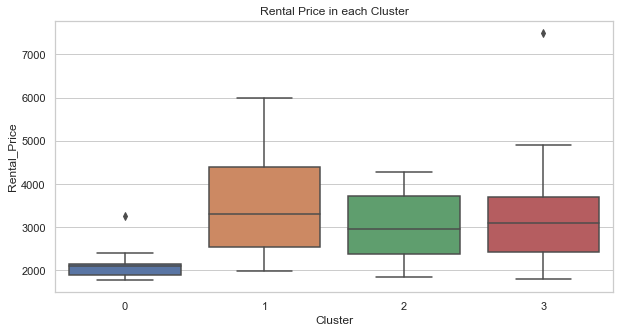

In [789]:
import matplotlib.pyplot as plt
import seaborn as sns

fig = plt.figure(figsize=(10,5))

sns.set(style='whitegrid')

plt.title('Rental Price in each Cluster')

ax = sns.boxplot(x='Cluster', y='Rental_Price', data=merged_df_nonull)

plt.show()

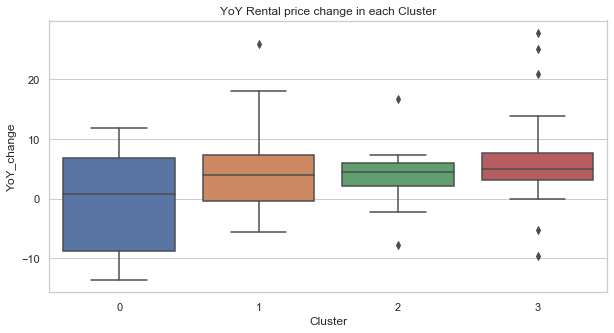

In [790]:
fig = plt.figure(figsize=(10,5))

sns.set(style='whitegrid')

plt.title('YoY Rental price change in each Cluster')

ax = sns.boxplot(x='Cluster', y='YoY_change', data=merged_df_nonull)

plt.show()

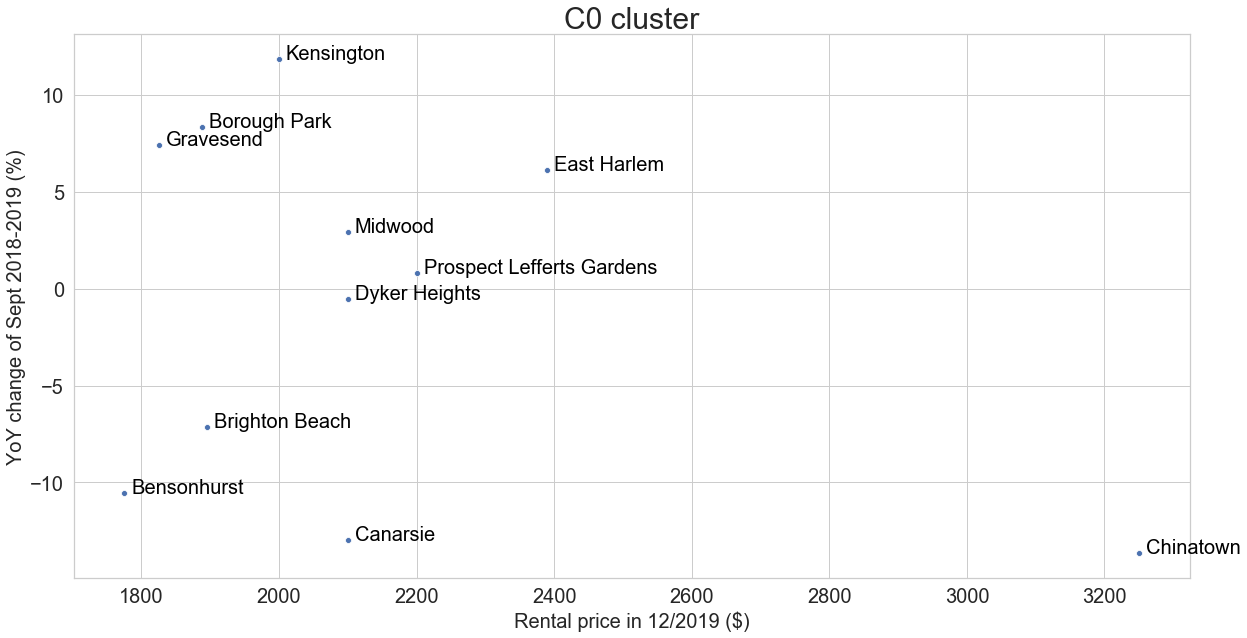

In [793]:
#C0.reset_index(inplace=True)

plt.figure(figsize=(20,10))

Graph = sns.scatterplot(x='Rental_Price', y='YoY_change', data=C0)
Graph.axes.set_title("C0 cluster", fontsize=30)
Graph.set_xlabel("Rental price in 12/2019 ($)", fontsize=20)
Graph.set_ylabel("YoY change of Sept 2018-2019 (%)", fontsize=20)
Graph.tick_params(labelsize=20)

for line in range(0,C0.shape[0]):
     Graph.text(C0['Rental_Price'].loc[line]+10, C0['YoY_change'].loc[line], C0['ntaname'].loc[line], 
                horizontalalignment='left', size=20, color='black')
    


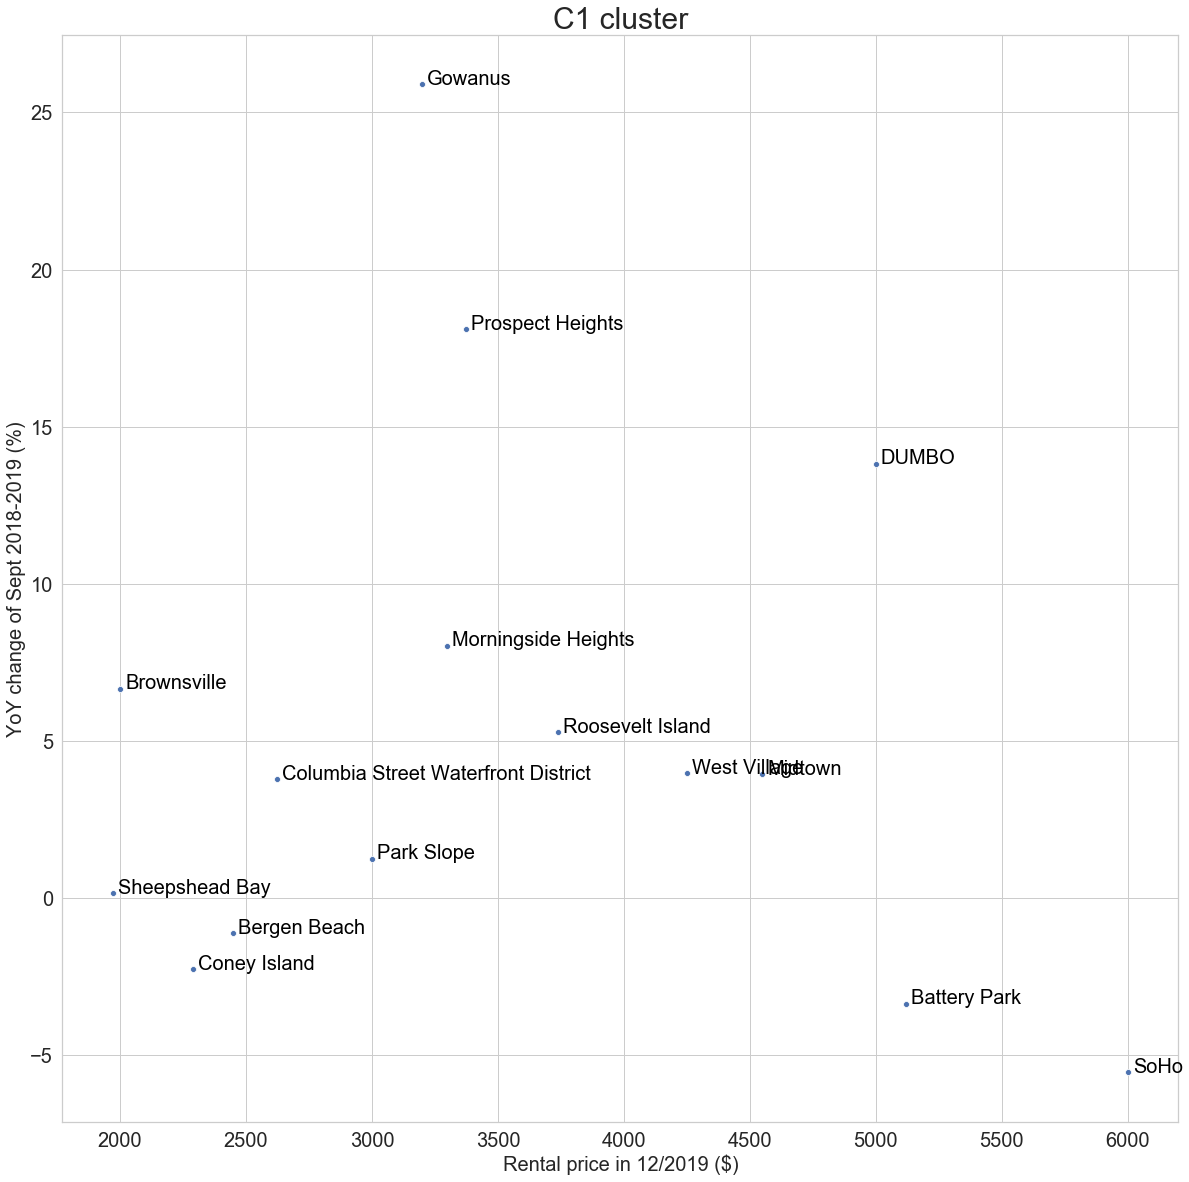

In [794]:
C1.reset_index(inplace=True)

plt.figure(figsize=(20,20))

Graph = sns.scatterplot(x='Rental_Price', y='YoY_change', data=C1)
Graph.axes.set_title("C1 cluster", fontsize=30)
Graph.set_xlabel("Rental price in 12/2019 ($)", fontsize=20)
Graph.set_ylabel("YoY change of Sept 2018-2019 (%)", fontsize=20)
Graph.tick_params(labelsize=20)

for line in range(0,C1.shape[0]):
     Graph.text(C1['Rental_Price'].loc[line]+20, C1['YoY_change'].loc[line], C1['ntaname'].loc[line], 
                horizontalalignment='left', size=20, color='black')
    


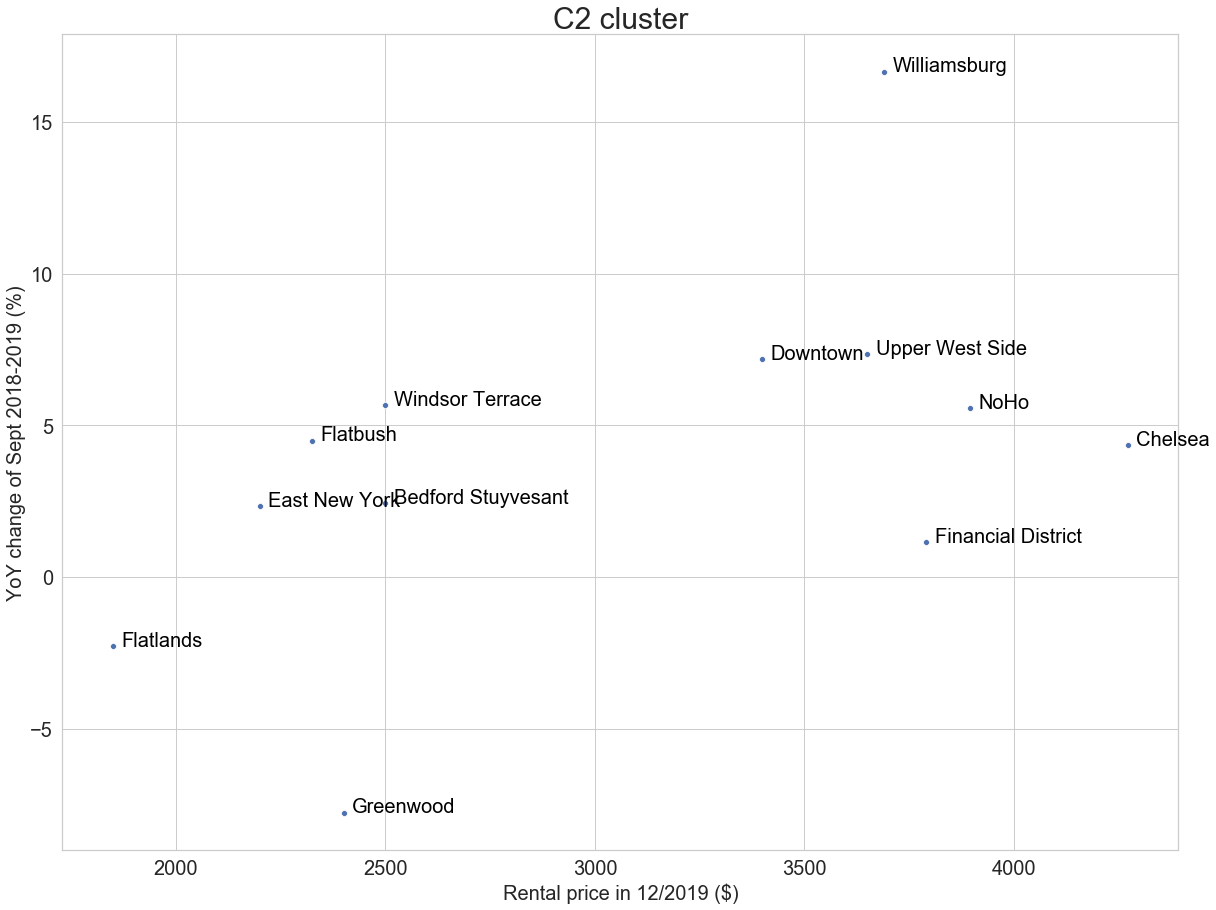

In [801]:
C2.reset_index(inplace=True)

plt.figure(figsize=(20,15))

Graph = sns.scatterplot(x='Rental_Price', y='YoY_change', data=C2)
Graph.axes.set_title("C2 cluster", fontsize=30)
Graph.set_xlabel("Rental price in 12/2019 ($)", fontsize=20)
Graph.set_ylabel("YoY change of Sept 2018-2019 (%)", fontsize=20)
Graph.tick_params(labelsize=20)

for line in range(0,C2.shape[0]):
     Graph.text(C2['Rental_Price'].loc[line]+20, C2['YoY_change'].loc[line], C2['ntaname'].loc[line], 
                horizontalalignment='left', size=20, color='black')
    


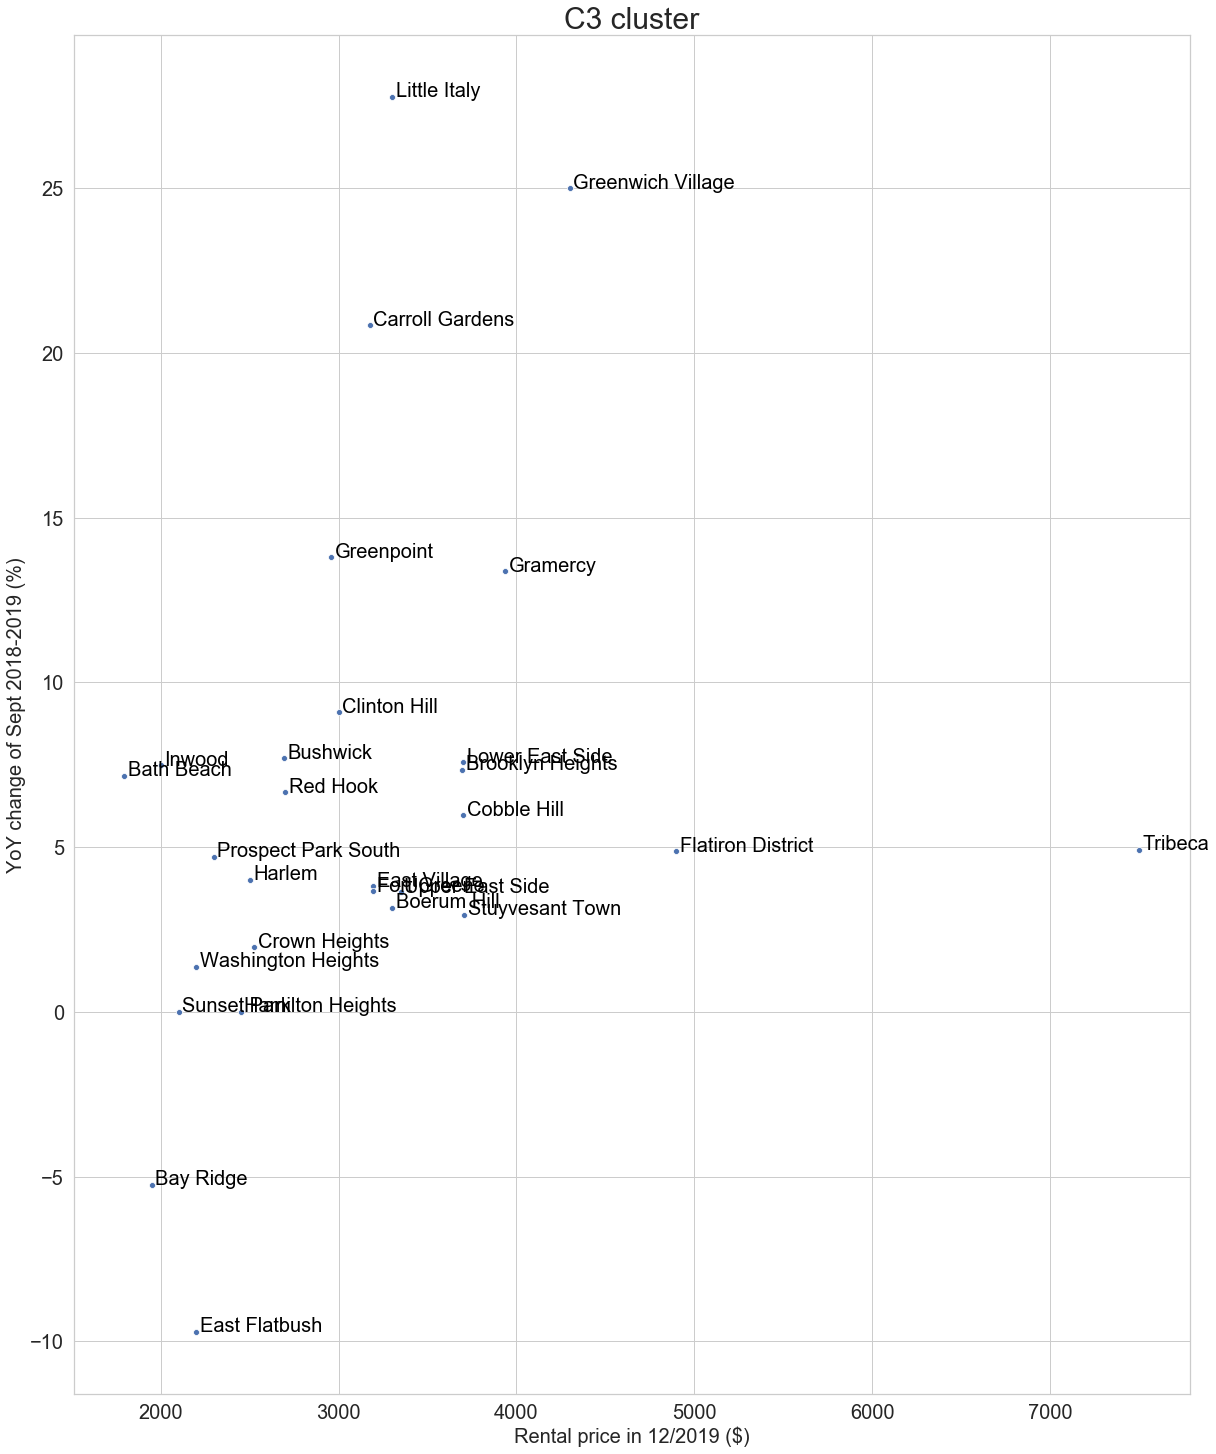

In [798]:
#C3.reset_index(inplace=True)

plt.figure(figsize=(20,25))

Graph = sns.scatterplot(x='Rental_Price', y='YoY_change', data=C3)
Graph.axes.set_title("C3 cluster", fontsize=30)
Graph.set_xlabel("Rental price in 12/2019 ($)", fontsize=20)
Graph.set_ylabel("YoY change of Sept 2018-2019 (%)", fontsize=20)
Graph.tick_params(labelsize=20)

for line in range(0,C3.shape[0]):
     Graph.text(C3['Rental_Price'].loc[line]+20, C3['YoY_change'].loc[line], C3['ntaname'].loc[line], 
                horizontalalignment='left', size=20, color='black')
    
